In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
import matplotlib.ticker as ticker
%matplotlib inline

import torch
import gc
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
start_token = "_"
eos = '#'
MAX_LENGTH = 40

In [0]:
data_pairs = pd.read_csv("drive/diploma/base_pairs.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x:  x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [0]:
s = "".join(data_pairs.word_norm)
tokens = np.sort(np.array(list(set(s))))
    
tok2id = dict(zip(tokens, np.arange(tokens.shape[0])))
id2tok = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens))

print('Vocabular: ' + "".join(tokens))

# np.save('drive/diploma/vocabulary/tok2id.npy', tok2id) 

# np.save('drive/diploma/vocabulary/id2tok.npy', id2tok) 

There are {} tokens 48
Vocabular: #'-0123456789_абвгдежзийклмнопрстуфхцчшщъыьэюяё’


In [0]:
import re

set_morph = set()
for i in range(data_pairs.shape[0]):
  loc = re.split(",| ", data_pairs.morph_features_form.values[i])
  for elem in loc:
    set_morph.add(elem)
tokens_f = np.sort(np.array(list(set_morph)))

tok2id_f = dict(zip(tokens_f, np.arange(tokens_f.shape[0])))
# id2tok_f = dict(zip(np.arange(tokens.shape[0]), tokens))

# np.save('drive/diploma/vocabulary/tok2id_f.npy', tok2id_f) 

print ('There are {} tokens',len(tokens_f))

print('Vocabular: ' + "".join(tokens_f))

There are {} tokens 100
Vocabular: 1per2per3perADJFADJSADVBAbbrAdjxAf-pAnphAnumAproArchCOMPCONJCmp2CollCounDistDmnsErroFimpFixdGNdrGRNDGeoxHypoINFNINTJImpeImpxInfrInitInmxLitrMs-fNOUNNPRONUMRNameOrgnPRCLPREDPREPPRTFPRTSPatrPltmPossPrdxPrntQualQuesSgtmSlngSubxSuprSurnV-beV-biV-ejV-enV-eyV-ieV-oyV-shVERBVpreabltaccsactvanimdatvexclfemnfutrgen1gen2gentimpfimprinaninclindcintrloc1loc2loctmascms-fneutnomnpastperfplurprespssvsingtranvoct


In [0]:
SOS_token = tok2id[start_token]
EOS_token = tok2id[eos]

In [0]:
def to_matrix(words, max_len=None, pad=tok2id[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
print('\n'.join(data_pairs.word_form[:10]))
print(to_matrix(data_pairs.word_form[:10]))

ежа#
ежу#
ежа#
ежом#
еже#
ежи#
ежей#
ежам#
ежей#
ежами#
[[19 20 14  0  0  0]
 [19 20 33  0  0  0]
 [19 20 14  0  0  0]
 [19 20 28 26  0  0]
 [19 20 19  0  0  0]
 [19 20 22  0  0  0]
 [19 20 19 23  0  0]
 [19 20 14 26  0  0]
 [19 20 19 23  0  0]
 [19 20 14 26 22  0]]


In [0]:
tok2id_f[eos] = 100

def to_matrix_f(words, max_len=None, pad=tok2id_f[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id_f.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
indices = data_pairs.lex_id.unique()
np.random.seed(42)
np.random.shuffle(indices)
data_pairs.set_index("lex_id", inplace=True)
train = data_pairs.loc[indices[:int(0.8 * indices.shape[0])]]
input_train = train.drop("word_form", axis=1)
target_train = train.word_form.values

test = data_pairs.loc[indices[int(0.8 * indices.shape[0]):]]
input_test = test.drop("word_form", axis=1)
target_test = test.word_form.values

In [0]:
class pairs_Dataset(Dataset):
    def __init__(self, data, data_form):
        self.data = data
        self.target = data_form
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data.word_norm.values[index], self.data.morph_features_form.values[index], self.target[index], self.data.morph_features_norm.values[index]

In [0]:
BATCH_SIZE = 512

train_data = pairs_Dataset(input_train, target_train)

dataset = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_data = pairs_Dataset(input_test, target_test)

test_batches = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [0]:
for batch in dataset:
    print(batch)
    print(batch[1])
    break

[('_тяжеливший#', '_броузер#', '_гофрировавшийся#', '_амфиктионический#', '_поселяющийся#', '_трактирнее#', '_беспросыпен#', '_толкованный#', '_разруганный#', '_кордовый#', '_временный#', '_рулька#', '_елистратович#', '_разгуляться#', '_цопнут#', '_растерзал#', '_плоскогрудый#', '_обмочить#', '_насумасбродивший#', '_харкавший#', '_горизонтальность#', '_арабистика#', '_укрепивший#', '_продешевивший#', '_незаявленный#', '_состригший#', '_обмеблированный#', '_ксеродерма#', '_пшеничникова#', '_хозрасчётный#', '_полистен#', '_оборонэкспорт#', '_пропионовый#', '_заполучающий#', '_несожженный#', '_впаиваю#', '_состряпанный#', '_пощёлканный#', '_намусоливающий#', '_передваивающийся#', '_сангвиник#', '_джалалутдин#', '_седиментометрический#', '_совращение#', '_маслобарьерный#', '_перегрунтовываемый#', '_диора#', '_грушко#', '_валуев#', '_подставляющий#', '_систематизирующийся#', '_компьютеризировавший#', '_дмитриан#', '_музыкантша#', '_каданников#', '_лепка#', '_травосеяние#', '_термоэлектричес

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, morph_feat_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.morph_size = morph_feat_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, morph_feat, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
                
        output = torch.cat((embedded[0], attn_applied.squeeze(), morph_feat[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
teacher_forcing_ratio = 0.5

def train_batch(X, X_f, y, encoder, encoder_f, decoder, encoder_opt, encoder_f_opt, decoder_opt, criterion, lr, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_hidden_f = encoder_f.initHidden()
    
    encoder.train()
    encoder_f.train()
    decoder.train()
    
    encoder_opt.zero_grad()
    encoder_f_opt.zero_grad()
    decoder_opt.zero_grad()
    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    loss = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]
    for i in range(X_f.shape[1]):
        encoder_output_f, encoder_hidden_f = encoder_f(
            X_f[:, i], encoder_hidden_f)

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, encoder_hidden_f, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, y[:, di])
            decoder_input = y[:, di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, encoder_hidden_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, y[:, di])

    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(encoder_f.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
    for p in encoder.parameters():
      p.data.add_(-lr, p.grad.data)
    for p in encoder_f.parameters():
      p.data.add_(-lr, p.grad.data)
    for p in decoder.parameters():
      p.data.add_(-lr, p.grad.data)
    encoder_opt.step()
    encoder_f_opt.step()
    decoder_opt.step()

    return loss.item()

In [0]:
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.grid()
    plt.show()
    
    
def test(encoder, encoder_f, decoder, criterion, test_batches, loss_log, acc_log):
    encoder.eval()
    encoder_f.eval()
    decoder.eval()
    for batch_num, batch in zip(trange(len(test_batches)), test_batches):
        encoder_hidden = encoder.initHidden()
        encoder_hidden_f = encoder_f.initHidden()
        max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
        X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
        X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]))).to(device)
        y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
        
        max_length = X.shape[1]
        encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
        loss = 0
        acc = 0
        for i in range(X.shape[1]):
            encoder_output, encoder_hidden = encoder(
                X[:, i], encoder_hidden)
            encoder_outputs[:, i] = encoder_output[0]
            
        for i in range(X_f.shape[1]):
            encoder_output_f, encoder_hidden_f = encoder_f(
                X_f[:, i], encoder_hidden_f)
            
        decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

        decoder_hidden = encoder_hidden
        decoder_pred = []
        for di in range(y.shape[1]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, encoder_hidden_f, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, y[:, di])
            decoder_pred.append(decoder_input.cpu())
        res = np.vstack(decoder_pred).T
        pred_res = ["".join(id2tok[_] for _ in res[i]) for i in range(res.shape[0])]
        true_res = ["".join(id2tok[_] for _ in y.cpu().numpy()[i]) for i in range(y.shape[0])]
        acc = accuracy_score(pred_res, true_res)
        loss_log.append(float(loss) / X.shape[0])
        acc_log.append(acc)

    plot_history(loss_log, title="Test")
    plot_history(acc_log, title="Accuracy")
    print("Mean accuracy - {}".format(np.mean(acc_log)))
    return loss_log

def train(data, test_batches, encoder, encoder_f, decoder, encoder_optimizer, decoder_optimizer, encoder_f_optimizer, n_epochs, print_every=1, plot_every=1, lr=0.05):
    start = time.time()
    plot_losses = []
    loss_log = []
    acc_log = []
    criterion = nn.NLLLoss()
    lr_decay_base = 1 / 1.15
    m_flat_lr = 10.0
    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        loss = 0
        lr_decay = lr_decay_base ** max(epoch - m_flat_lr, 0)
        lr = lr * lr_decay
        for batch_num, batch in zip(trange(len(data)), data):
            max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
            X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
            X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]))).to(device)
            y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
            loss = train_batch(X, X_f, y, encoder, encoder_f,
                     decoder, encoder_optimizer, encoder_f_optimizer, decoder_optimizer, criterion, lr)
            plot_losses.append(loss / X.shape[0])
        clear_output()
        gc.collect()
        print("Loss - {}".format(loss))
        print("Epoch - {}".format(epoch))
        plot_history(plot_losses, "Train")
        torch.save({
            'encoder1_state_dict': encoder.state_dict(),
            'encoder2_state_dict': encoder_f.state_dict(),
            'attn_decoder1_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'encoder_f_optimizer_state_dict': encoder_f_optimizer.state_dict(),
            'plot_losses': plot_losses,
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
            }, "drive/diploma/two_encoders_one_attention/SGD_new_two_encoders_unidir_GRU_{}".format(epoch))
    gc.collect()
    test(encoder, encoder_f, decoder, criterion, test_batches, loss_log, acc_log)
        

In [0]:
hidden_size = 256
learning_rate = 0.01
encoder1 = EncoderRNN(tokens.shape[0], hidden_size).to(device)
encoder2 = EncoderRNN(tokens_f.shape[0] + 1, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, tokens.shape[0], tokens_f.shape[0] + 1, dropout_p=0.1).to(device)

encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=learning_rate)
encoder_f_optimizer = optim.SGD(encoder2.parameters(), lr=learning_rate)


In [0]:
# 5 + 7 +
train(dataset, test_batches, encoder1, encoder2, attn_decoder1, encoder_optimizer, decoder_optimizer, encoder_f_optimizer, 20)

  2%|▏         | 176/7422 [00:26<18:46,  6.43it/s]

100%|██████████| 1860/1860 [03:24<00:00,  9.46it/s]


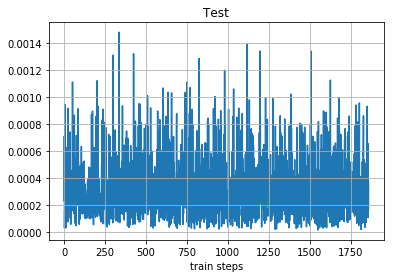

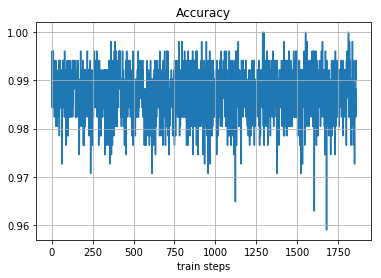

Mean accuracy - 0.9871996807795699


[0.00023589130432810634,
 0.0007119523943401873,
 3.5163742722943425e-05,
 0.00016309128841385245,
 0.00011010844173142686,
 0.0009448400232940912,
 0.00033078447449952364,
 0.00017322218627668917,
 0.0002452499757055193,
 0.00015765393618494272,
 3.3777207136154175e-05,
 0.0005125142633914948,
 0.00022180659289006144,
 0.00022344438184518367,
 0.00022599706426262856,
 0.0002150254149455577,
 0.0002045946312136948,
 0.0001890596468001604,
 0.0001982854155357927,
 0.0006326765869744122,
 8.729862020118162e-05,
 0.00018638554320205003,
 0.000440573989180848,
 0.0007308662170544267,
 0.0009181221830658615,
 7.885492232162505e-05,
 0.00016468438843730837,
 0.000503424322232604,
 0.00028265354922041297,
 0.00018568753148429096,
 0.0002976719115395099,
 0.00032843195367604494,
 0.00020829206914640963,
 0.0004273968224879354,
 0.0002958824916277081,
 0.00045522701111622155,
 0.0007431363337673247,
 0.00045931251952424645,
 0.00010545277473283932,
 0.00024135438434313983,
 6.013315578456968e-0

In [0]:
# 6 epochs
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, encoder2, attn_decoder1, criterion, test_batches, loss_log, acc_log)

In [0]:
checkpoint = torch.load("drive/diploma/two_encoders_one_attention/ADAM_two_encoders_unidir_GRU_9")
encoder1.load_state_dict(checkpoint['encoder1_state_dict'])
encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])

encoder2.load_state_dict(checkpoint['encoder2_state_dict'])
encoder_f_optimizer.load_state_dict(checkpoint['encoder_f_optimizer_state_dict'])


attn_decoder1.load_state_dict(checkpoint['attn_decoder1_state_dict'])
decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])


100%|██████████| 1860/1860 [03:24<00:00,  9.41it/s]


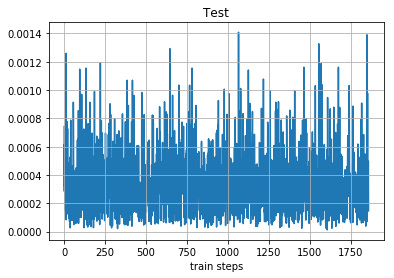

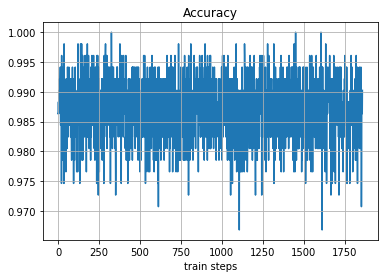

Mean accuracy - 0.9871996807795699


[0.0007420825422741473,
 0.0002849079028237611,
 0.0006190744461491704,
 0.0003213070158381015,
 0.0003658569185063243,
 0.00015205233648885041,
 0.0003440440050326288,
 0.0002574786194600165,
 0.0005860383971594274,
 0.0001014819645206444,
 0.00035470188595354557,
 0.001259217387996614,
 8.389365393668413e-05,
 0.00012144274660386145,
 0.00016993051394820213,
 0.00018624338554218411,
 0.0003546105872374028,
 0.0007773172692395747,
 0.00031678599771112204,
 0.0003317031660117209,
 0.00023692791000939906,
 0.000727553793694824,
 0.00012525236525107175,
 0.0004512609448283911,
 0.0002988083870150149,
 0.000436362432083115,
 0.00033252930734306574,
 0.00048469737521372736,
 0.00042244174983352423,
 0.000173730164533481,
 9.373977081850171e-05,
 0.0001546525163576007,
 0.00012226947001181543,
 7.18848459655419e-05,
 0.00013011161354370415,
 0.0005252990522421896,
 0.0003664795949589461,
 2.660796235431917e-05,
 0.0001712289813440293,
 0.00028080574702471495,
 0.0007873349823057652,
 0.0001

In [0]:
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, encoder2, attn_decoder1, criterion, test_batches, loss_log, acc_log)


In [0]:
dtorch.save({
    'encoder1_state_dict': encoder1.state_dict(),
    'encoder2_state_dict': encoder2.state_dict(),
    'attn_decoder1_state_dict': attn_decoder1.state_dict(),
    'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
    'encoder_f_optimizer_state_dict': encoder_f_optimizer.state_dict(),
    'decoder_optimizer_state_dict': decoder_optimizer.state_dict()
    }, "drive/diploma/two_encoders_one_attention/final_model_24_epochs_099")

In [0]:
checkpoint = torch.load("drive/diploma/two_encoders_one_attention/two_encoders_unidir_GRU_19")


In [0]:
def test_att(encoder, encoder_f, decoder, criterion, batch, loss_log, acc_log):
    encoder.eval()
    encoder_f.eval()
    decoder.eval()
    res_att = []
    res_words = []
    encoder_hidden = encoder.initHidden()
    encoder_hidden_f = encoder_f.initHidden()
    max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
    X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
    X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
    y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)

    max_length = X.shape[1]
    encoder_outputs = torch.zeros(BATCH_SIZE, max_length, encoder.hidden_size, device=device)
    encoder_outputs_f = torch.zeros(BATCH_SIZE, 11, encoder.hidden_size, device=device)
    decoder_attentions = torch.zeros(BATCH_SIZE, max_length, max_length)
    loss = 0
    acc = 0
    for i in range(X.shape[1]):
        encoder_output, encoder_hidden = encoder(
            X[:, i], encoder_hidden)
        encoder_outputs[:, i] = encoder_output[0]

    for i in range(X_f.shape[1]):
        encoder_output_f, encoder_hidden_f = encoder_f(
            X_f[:, i], encoder_hidden_f)
        encoder_outputs_f[:, i] = encoder_output_f[0]

    decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

    decoder_hidden = encoder_hidden
    decoder_pred = []
    for di in range(y.shape[1]):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, encoder_hidden_f, decoder_hidden, encoder_outputs)
        decoder_attentions[:, di] = decoder_attention.data
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        loss += criterion(decoder_output, y[:, di])
        decoder_pred.append(decoder_input.cpu())
    res = np.vstack(decoder_pred).T
    pred_res = ["".join(id2tok[_] for _ in res[i]) for i in range(res.shape[0])]
    true_res = ["".join(id2tok[_] for _ in y.cpu().numpy()[i]) for i in range(y.shape[0])]
    res_words.append(pred_res)
    res_att.append(decoder_attentions)
    return res_words, res_att
  
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(input_sentence, rotation=90, fontsize=30)
    ax.set_yticklabels(output_words, fontsize=30)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

  0%|          | 0/1860 [00:00<?, ?it/s]

X ('_предшествующий#', '_ординальный#', '_заерепенившийся#', '_спитой#', '_досмаливающийся#', '_смущённый#', '_пример#', '_геотропический#', '_отчаивавшийся#', '_засусливаю#', '_сбавлявший#', '_затюковывавшийся#', '_подсидка#', '_музаффоровна#', '_эндотоксин#', '_задрапировывавший#', '_сарагоса#', '_центрифугированный#', '_закатывающий#', '_пристальный#', '_подтёсываемый#', '_барометр#', '_натрусившийся#', '_увязываемый#', '_утолщаюсь#', '_продрался#', '_обскабливаемый#', '_остросюжетный#', '_новосибирсккиновидеосервис#', '_стах#', '_неинформационный#', '_смокинговый#', '_невоздержанный#', '_маршевее#', '_судим#', '_вулканизуемый#', '_деру#', '_нахлопывавший#', '_пленявшийся#', '_микрометр#', '_поостывший#', '_нарима#', '_вачировна#', '_пододравший#', '_экологодинамический#', '_гегельянство#', '_подекадный#', '_разминающийся#', '_тягость#', '_искусавший#', '_одноместный#', '_поздоровавшийся#', '_порастаявший#', '_запрудился#', '_фуникулёр#', '_раззванивавший#', '_ректифицирующийся#', '

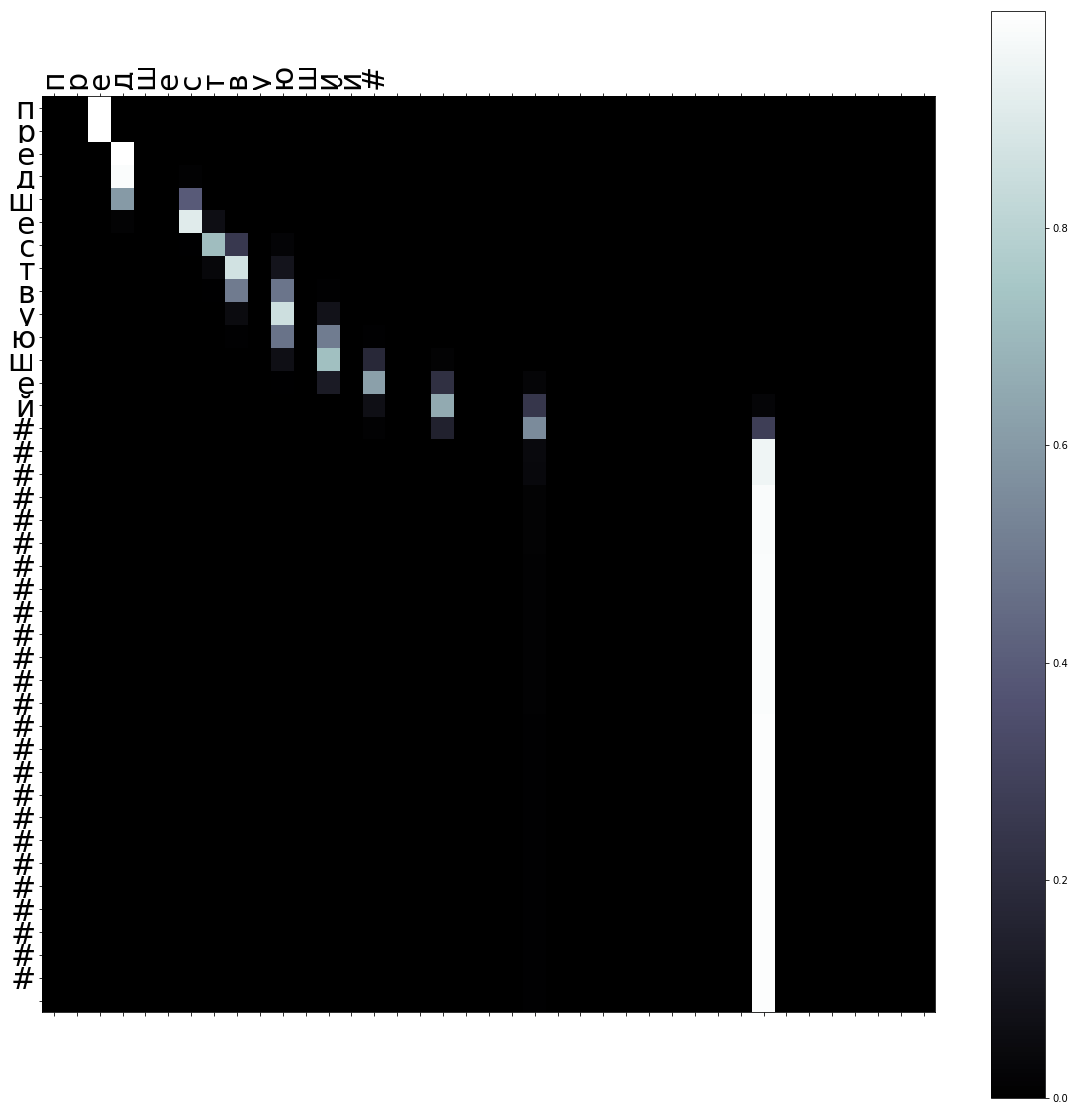

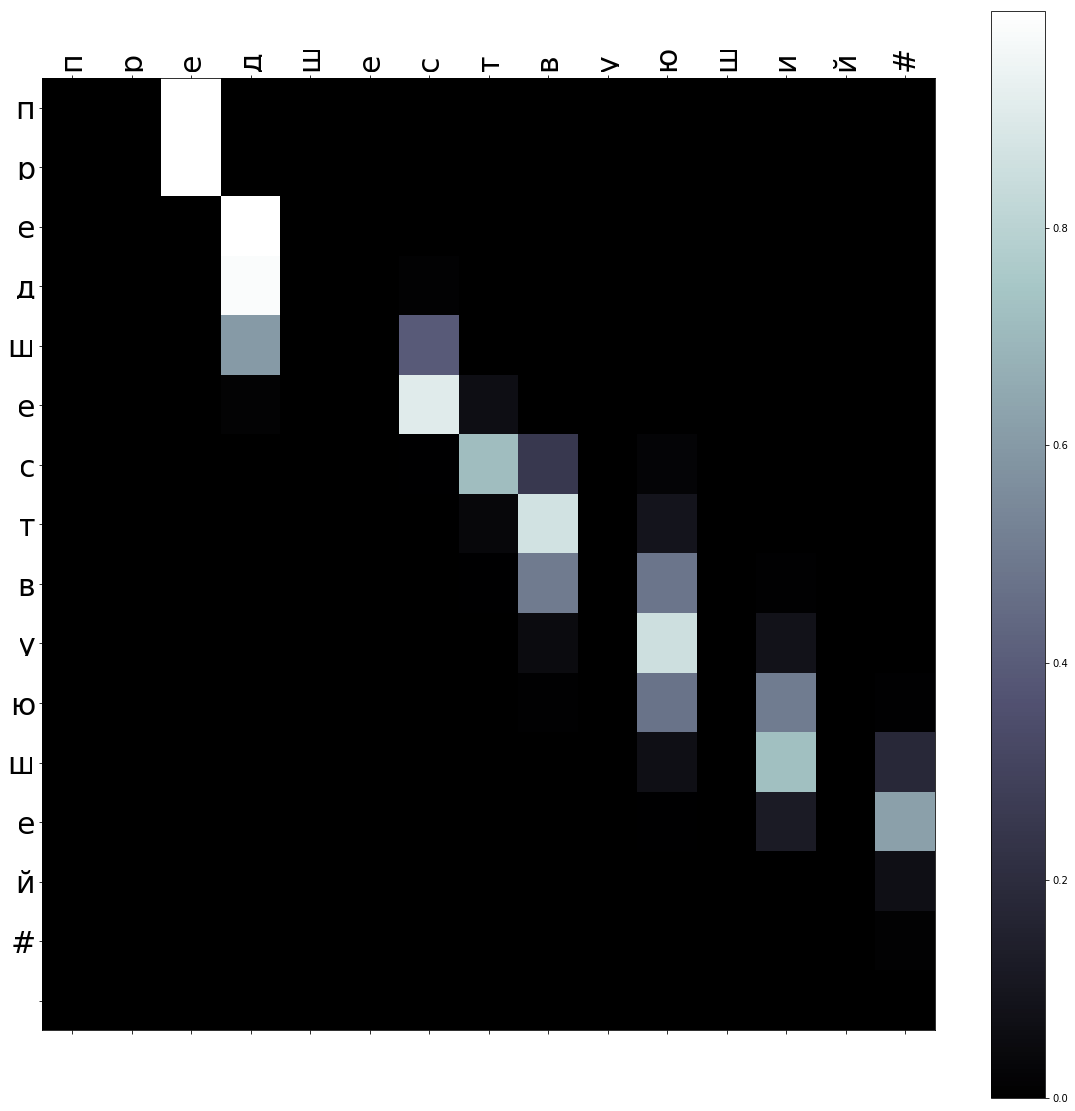

  0%|          | 2/1860 [00:02<34:35,  1.12s/it]

X ('_подпёкшись#', '_нехудожественнее#', '_скотнее#', '_закулисный#', '_незлобивый#', '_теплённый#', '_электроэнергетика#', '_серафический#', '_объемлющий#', '_лязгнувший#', '_тифоидный#', '_похерил#', '_ухообразный#', '_перекувыркивавшийся#', '_ленинтерфонд#', '_геннедий#', '_цапавшийся#', '_осоловевший#', '_вспрыскиваемый#', '_делюкины#', '_геоботанический#', '_структурообразующий#', '_отелявшийся#', '_зернистый#', '_намский#', '_тлящийся#', '_санчурский#', '_накидка#', '_услуживавший#', '_покатавший#', '_желтимый#', '_скукоживающийся#', '_хлыщущийся#', '_крытый#', '_пломбированный#', '_обрезываемый#', '_бедный#', '_гиоид#', '_радула#', '_газотранспортный#', '_монтировочный#', '_зубатый#', '_взрыхляя#', '_передешевлённый#', '_акустик#', '_выпирающийся#', '_церемонничавший#', '_круторогий#', '_намотал#', '_делиевич#', '_тарахтевший#', '_растаскивавший#', '_лутфиевна#', '_пожирневший#', '_простиранный#', '_жук#', '_школюсь#', '_мыслимый#', '_чермнее#', '_подсадной#', '_жаркое#', '_биоф

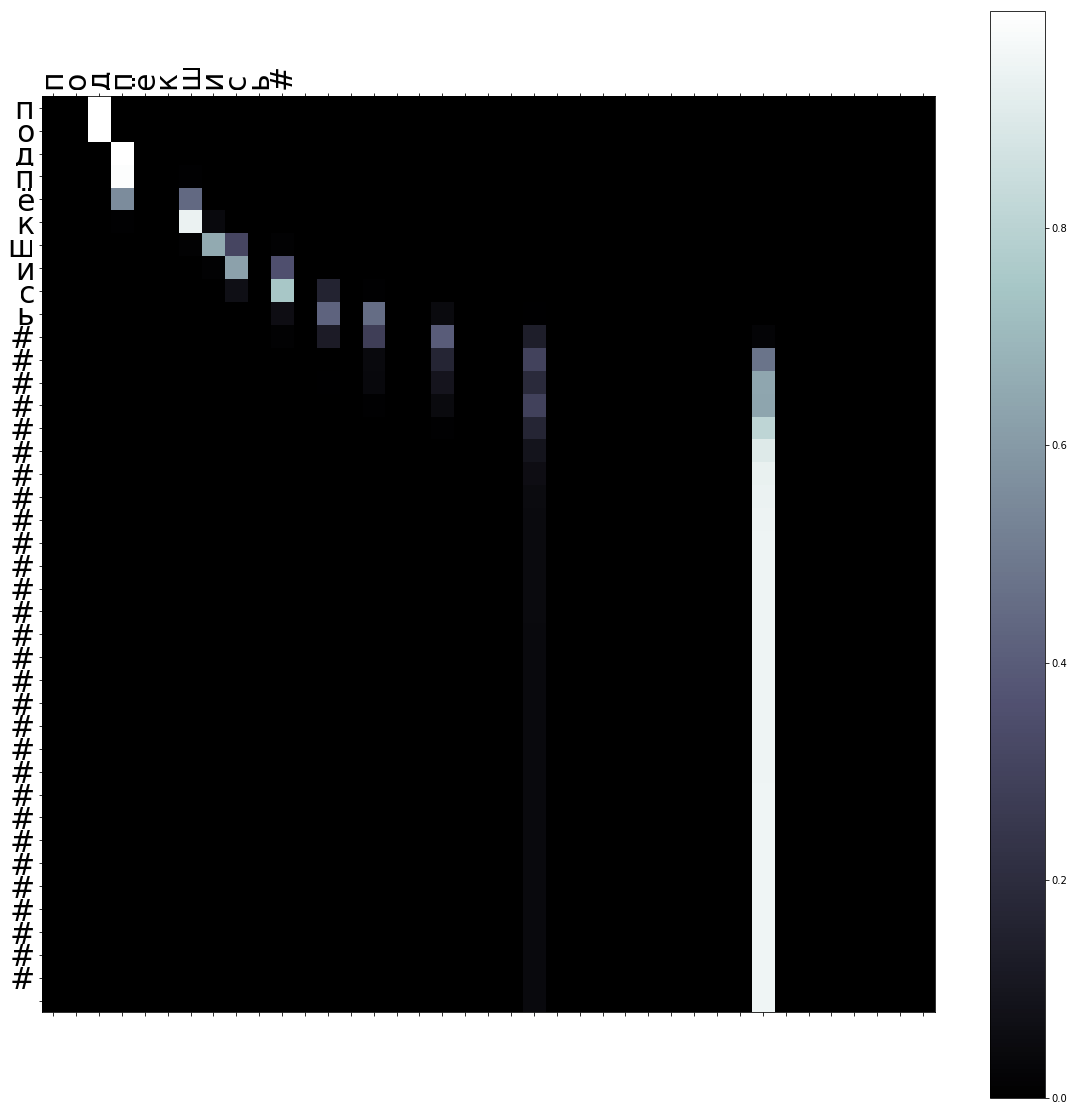

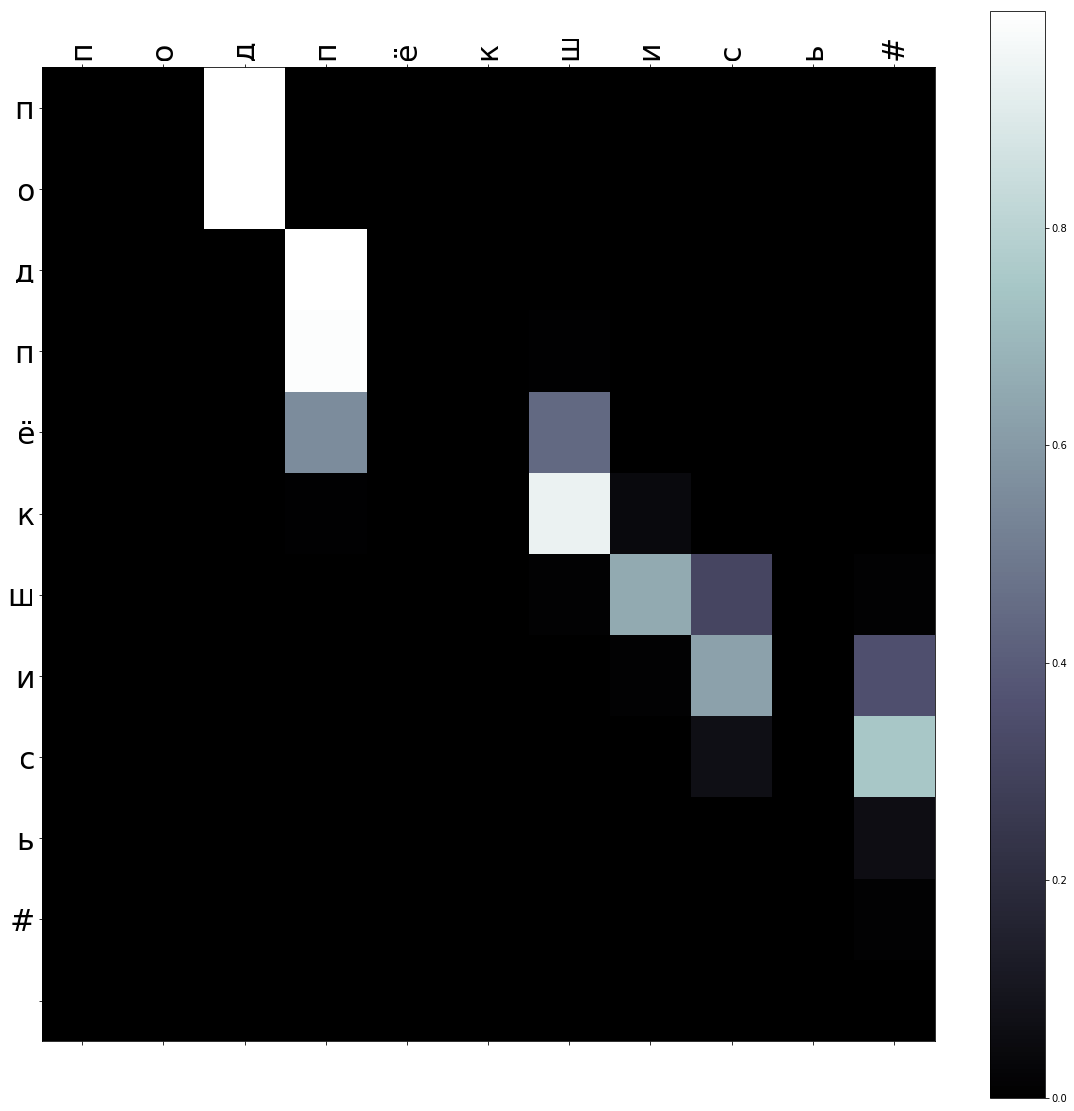

  0%|          | 3/1860 [00:04<40:50,  1.32s/it]

X ('_усердствую#', '_этапирующий#', '_переключил#', '_аусовна#', '_оргструктура#', '_макрон#', '_таинственнейший#', '_лакинск#', '_ломоть#', '_выкидавший#', '_некрапчатый#', '_ненавидящий#', '_выдраенный#', '_терпужный#', '_крамола#', '_миропомазывающий#', '_трубоглоточный#', '_специальный#', '_дуврский#', '_динас#', '_упёкший#', '_обживаемый#', '_трагопан#', '_гасконка#', '_заказанный#', '_добычливый#', '_выезживающийся#', '_отупивший#', '_выхлёстывающийся#', '_снискиваемый#', '_задуривший#', '_раскланиваюсь#', '_штыкующий#', '_выселенный#', '_биоакустик#', '_налёживаемый#', '_захронометрированный#', '_необезжиренный#', '_землетрясение#', '_искусывавшийся#', '_реченский#', '_нагорбившийся#', '_ереванка#', '_лейцит#', '_организовавший#', '_прикрывавший#', '_сизевший#', '_раскур#', '_насадной#', '_самнитский#', '_моднейший#', '_барботажный#', '_пристигнувший#', '_плечко#', '_информативный#', '_провинчивавший#', '_встревавший#', '_афтондиловна#', '_самодовлеющий#', '_нейроциркулярный#', 

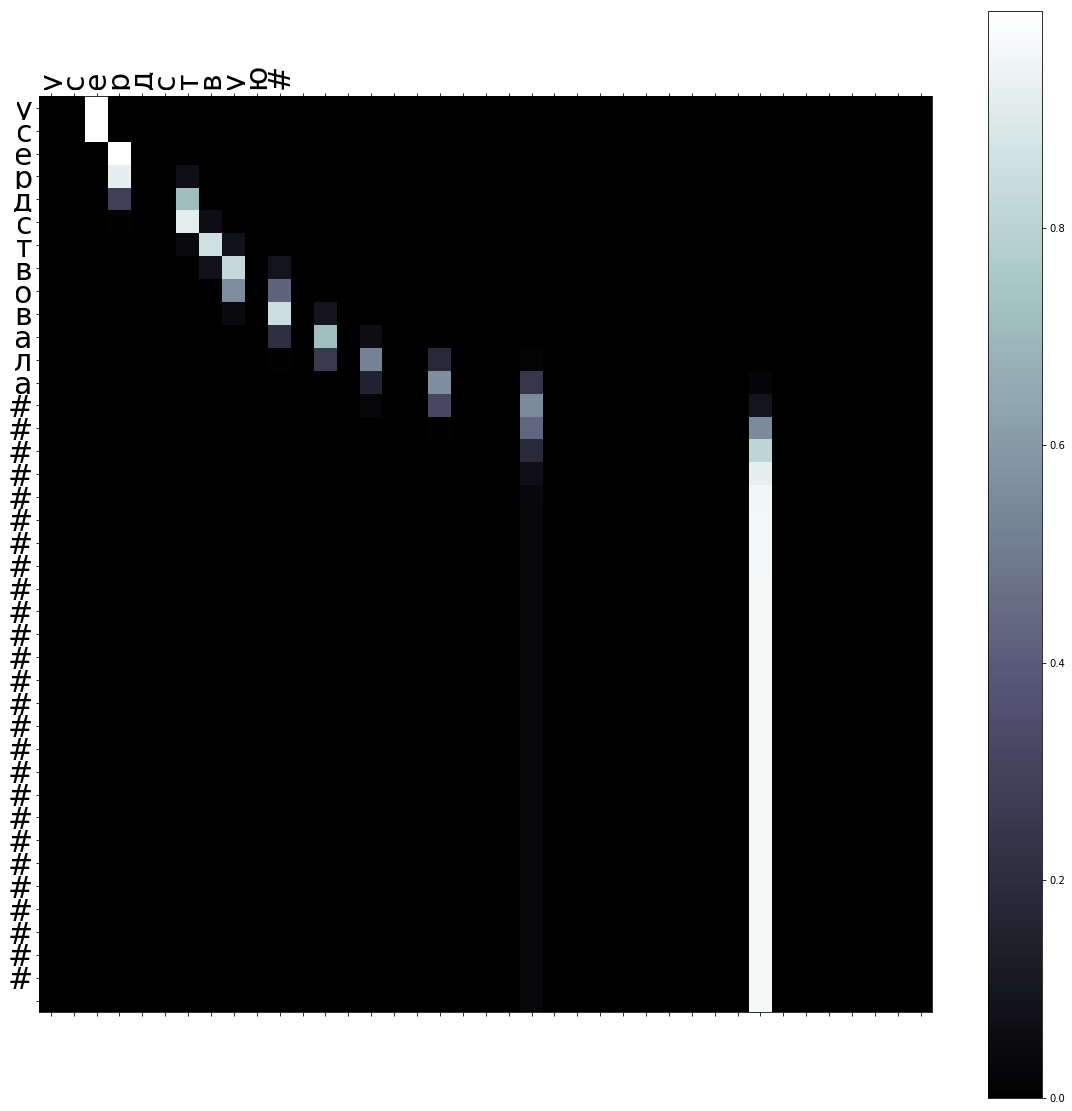

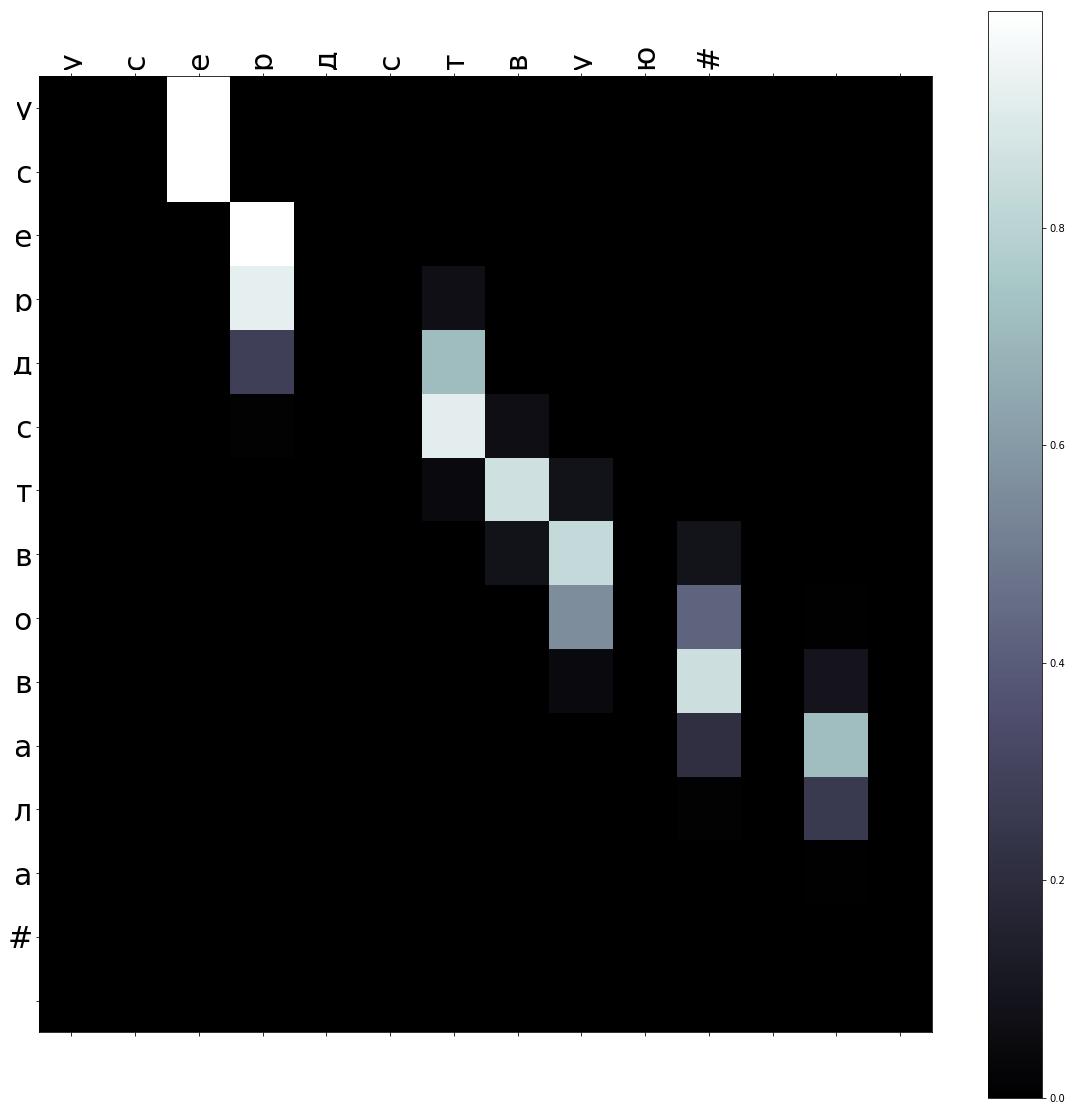

100%|██████████| 1860/1860 [00:26<00:00, 92.01it/s]


In [0]:
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
  if batch_num == 1 or batch_num == 2 or batch_num == 3:
    res_words, decoder_attentions  = test_att(encoder1, encoder2, attn_decoder1, criterion, batch, loss_log, acc_log)
    print("X {}".format(batch[0]))
    print("res_word {}".format(res_words[0]))
    print(decoder_attentions[0].shape)
    showAttention(batch[0][0], res_words[0][0], decoder_attentions[0][0][:, 1:])
    ind = 0
    for i, elem in enumerate(res_words[0][0]):
      if elem == "#":
        ind = i
        break
    showAttention(batch[0][0], res_words[0][0][:ind + 1], decoder_attentions[0][0][:ind + 1, 1:ind + 1])
    

In [0]:
data_pairs = pd.read_csv("drive/diploma/base_pairs_new.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x: x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,_ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,_ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,_ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,_ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,_еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [0]:
BATCH_SIZE = 512

input_data = data_pairs.drop("word_form", axis=1)
target = data_pairs.word_form.values

input_data = pairs_Dataset(input_data, target)
dataset_full = DataLoader(input_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

100%|██████████| 18566/18566 [34:35<00:00,  9.03it/s]


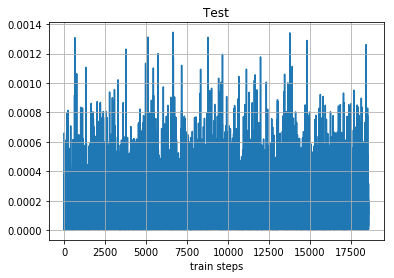

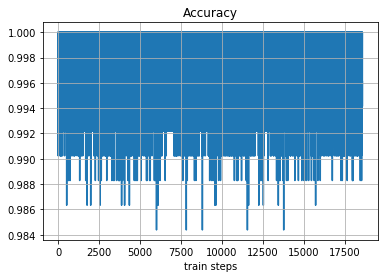

Mean accuracy - 0.9968612820478293


[1.3088378182146698e-05,
 3.902405296685174e-06,
 0.0002083712024614215,
 7.111067679943517e-05,
 7.77855166234076e-06,
 3.856057446682826e-06,
 0.00014523809659294784,
 2.3012118617771193e-05,
 1.4253593690227717e-05,
 0.0006608953117392957,
 4.213905776850879e-05,
 9.68413587543182e-06,
 1.1254578566877171e-05,
 0.0003109539102297276,
 7.426111551467329e-06,
 7.714814273640513e-06,
 5.868258813279681e-05,
 0.00028004939667880535,
 0.000377879710868001,
 1.780195816536434e-05,
 4.4405474909581244e-05,
 4.2441133700776845e-05,
 5.3296487749321386e-05,
 3.63621256838087e-05,
 1.9859442545566708e-05,
 6.911555101396516e-05,
 0.00012457594857551157,
 4.7503843234153464e-05,
 2.630007656989619e-06,
 2.7880771085619926e-05,
 0.0002415706985630095,
 0.00014527473831549287,
 5.0445949455024675e-05,
 4.703517333837226e-06,
 2.832094469340518e-05,
 5.588595740846358e-05,
 2.1318799554137513e-05,
 0.00011997116234852001,
 8.12886719359085e-06,
 0.0002283299108967185,
 8.583992894273251e-06,
 0.0

In [0]:
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(encoder1, encoder2, attn_decoder1, criterion, dataset_full, loss_log, acc_log)



In [0]:
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
    res_words, decoder_attentions = test_att(encoder1, encoder2, attn_decoder1, criterion, batch, loss_log, acc_log)
    y = to_matrix(batch[2], max_len=MAX_LENGTH)
    true_res = ["".join(id2tok[_] for _ in y[i]) for i in range(y.shape[0])]
    res_words = np.array(res_words[0])
    true_res = np.array(true_res)
    ret_res = np.copy(res_words)
    for j in range(ret_res.shape[0]):
      for i, elem in enumerate(ret_res[j]):
            if elem == "#":
              ret_res[j] = ret_res[j][:i] 
    y_ret = np.array(batch[2])
    for i, word in enumerate(y_ret):
      y_ret[i] = word[:-1]
    d = {"norm_form":np.array(batch[0])[res_words != true_res], "True label":y_ret[res_words != true_res], "Predicted":ret_res[res_words != true_res], "Norm morph features":np.array(batch[3])[res_words != true_res], "Transformed morph features":np.array(batch[1])[res_words != true_res]}
    mistakes = pd.concat([mistakes, pd.DataFrame(data=d)])  

100%|██████████| 1860/1860 [04:32<00:00,  6.95it/s]


In [0]:
mistakes

,norm_form,True label,Predicted,Norm morph features,Transformed morph features
0,_10-й#,_10-й,_12-ой,"ADJF,Abbr,Anum masc,sing,nomn","ADJF,Abbr,Anum femn,sing,loct"
1,_комипермяцкагропромтехснаб#,_комипермяцкагропромтехснабами,_комипермяцкагропромтехнабами,"NOUN,inan,masc,Orgn sing,nomn","NOUN,inan,masc,Orgn plur,ablt"
0,_ослизнув#,_ослизши,_ослизнувши,"GRND,perf,intr past","GRND,perf,intr past,V-sh"
1,_авелиевна#,_авельевне,_авелиевне,"NOUN,anim,femn,Patr sing,nomn,V-ie","NOUN,anim,femn,Patr sing,datv"
2,_мануфактур-коллегия#,_мануфактур-коллегию,_мануфактураколлегию,"NOUN,inan,femn sing,nomn","NOUN,inan,femn sing,accs"
3,_анзориевна#,_анзорьевны,_анзориевны,"NOUN,anim,femn,Patr sing,nomn,V-ie","NOUN,anim,femn,Patr plur,nomn"
4,_перёд#,_передов,_перёдов,"NOUN,inan,masc sing,nomn","NOUN,inan,masc plur,gent"
5,_ганец#,_ганцев,_ганцов,"NOUN,anim,masc sing,nomn","NOUN,anim,masc plur,gent"
0,_багрянённый#,_багряненным,_багрянённым,"PRTF,impf,tran,past,pssv masc,sing,nomn,Infr","PRTF,impf,tran,past,pssv neut,sing,ablt"
1,_заузил#,_заузьте,_заузите,"VERB,perf,tran masc,sing,past,indc","VERB,perf,tran plur,impr,excl"


In [0]:
mistakes.to_csv("drive/diploma/mistakes/mistake_model_one_attentions.csv")